In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math
import json
import plotly.express as px
import pandas as pd
import numpy as np

## 1. Load nodes and edges from JSON file

In [2]:
nodes = json.load(open('./genshin_data/node_list.json', 'rb'))
edges = json.load(open('./genshin_data/edge_list.json', 'rb'))

In [3]:
 # example look of the node_list JSON file
nodes[1]

{'id': 'Keqing', 'nation': 'Liyue'}

In [4]:
# example look of the edge_list JSON file
edges[1]

{'type': 'voice', 'from': 'Amber', 'to': 'Klee'}

In [5]:
%%time

# create directed graph
directed_graph = nx.DiGraph()

# add characters with a nation attribute
for node in nodes:
    directed_graph.add_node(node['id'], nation=node['nation'])

# add character relations
for edge in edges:
    directed_graph.add_edge(edge['from'], edge['to'], type=edge['type'])

Wall time: 1e+03 µs


In [6]:
# basic node and edge stats from networkx
print("Number of nodes:", directed_graph.number_of_nodes())
print("Number of edges:", directed_graph.number_of_edges())

Number of nodes: 35
Number of edges: 262


### In the Genshin Impact character network, we have 35 character nodes and 262 connections.

In [117]:
# setting node colours for drawing
nation_color_dict = {
    'Mondstadt': '#aff8db',
    'Liyue': '#ffcbc1',
    'Inazuma': '#d5aaff',
    'Snezhnaya': '#ace7ff'
}

# for each node, assign the node a color based on the
# the color map dictionary if the nation is existed in 
# the color map dictionary
node_colors = []
for node, nation in list(directed_graph.nodes(data="nation")):
    if nation in nation_color_dict:
        node_colors.append(nation_color_dict[nation])
    else:
        node_colors.append('#FFA500') # traveler doesn't belong to any nation

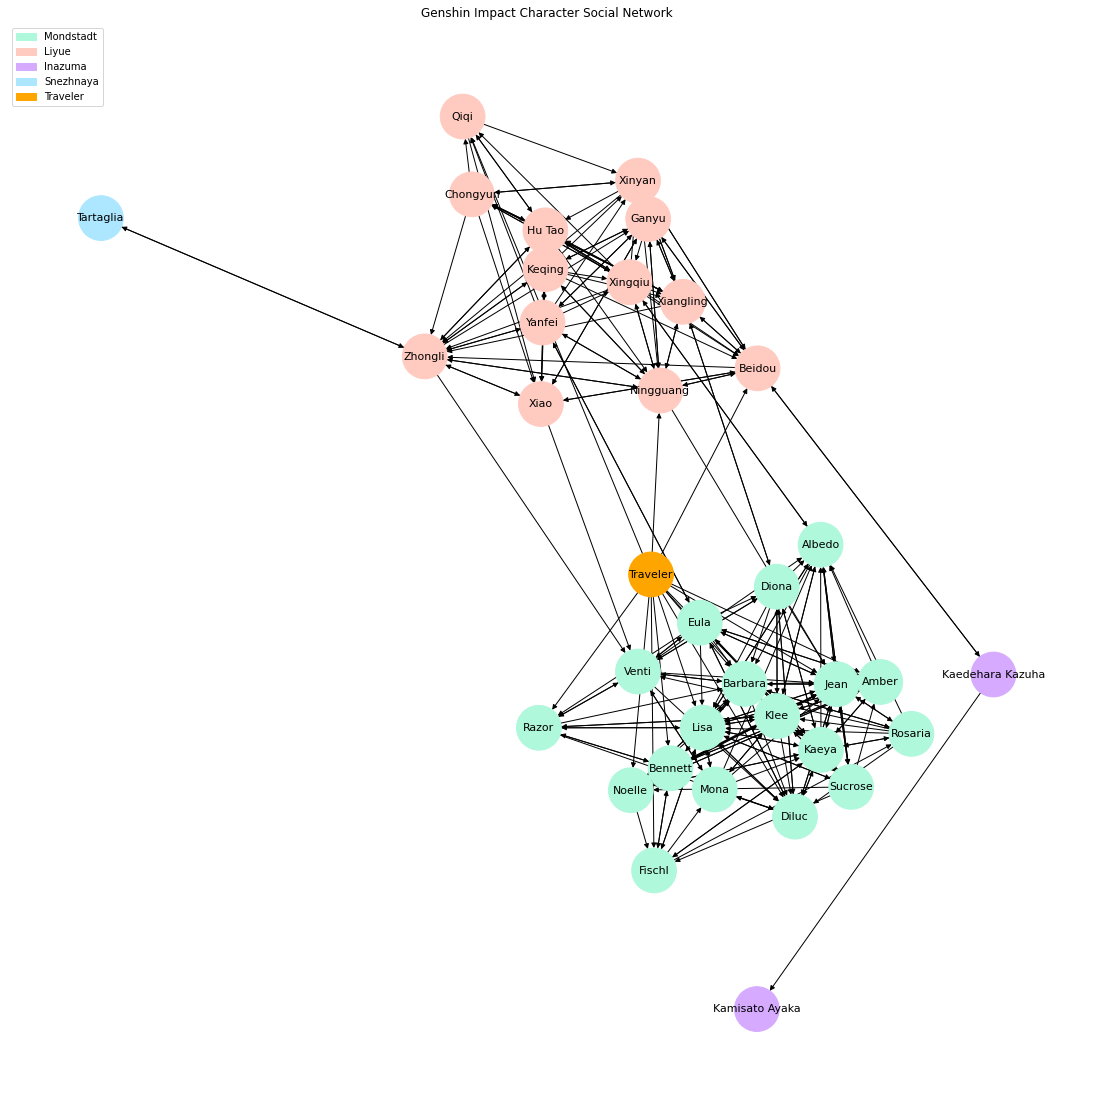

Wall time: 2.04 s


In [118]:
%%time

# create spring layout for 25 iterations to separate the nodes
np.random.seed(2021)
pos = nx.spring_layout(directed_graph, k=0.3, iterations=25)

plt.figure(1,figsize=(15,15)) 
nx.draw(directed_graph,
        pos = pos,
        node_size=2000,
        node_color=node_colors,
        with_labels=True,
        font_size = 11,
        font_color='black')

# create customized legend tiles
legend_tiles = [mpatches.Patch(color="#aff8db", label="Mondstadt"),
                mpatches.Patch(color="#ffcbc1", label="Liyue"),
                mpatches.Patch(color="#d5aaff", label="Inazuma"),
                mpatches.Patch(color="#ace7ff", label="Snezhnaya"),
                mpatches.Patch(color="#FFA500", label="Traveler"),
               ]
plt.title("Genshin Impact Character Social Network")
plt.legend(handles=legend_tiles, loc="upper left")
plt.show()

## Description Statistics:

## 2. Centrality / Node Importance
What characterizes an important node?

### 2.1 Degree centrality (local importance)

1. Assumption: important nodes have many connections.
2. Definition: measure node n’s importance by the degree of node n over total number of nodes
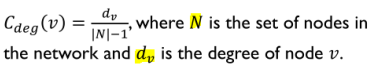
3. Interpretation: which node is the most important one with the most number of connections/friends/followers?

### Since the graph is directed, we will have in-degree and out-degree centrality.

In [18]:
in_degree_centrality_df = pd.DataFrame(nx.in_degree_centrality(directed_graph).items(), 
                                       columns=["node", "in_degree_centrality"])
in_degree_centrality_df.sort_values("in_degree_centrality", ascending=False).head(10)

,node,in_degree_centrality
34,Jean,0.500000
24,Lisa,0.441176
5,Kaeya,0.382353
6,Klee,0.382353
10,Diluc,0.352941
19,Barbara,0.323529
4,Zhongli,0.323529
16,Albedo,0.323529
15,Beidou,0.294118
12,Ningguang,0.294118


### Jean has the highest in-degree centrality. This implies Jean is mostly mentioned by other character in their storyline and voice memo.

In [46]:
# for a given graph and an important node,
# return suitable node color list for visualization
def get_centrality_node_colors(graph, important_node):
    node_colors = ["#EFD1BB"] * len(graph.nodes())
    node_colors[list(graph.nodes()).index(important_node)] = "#F47315"
    return node_colors

In [19]:
out_degree_centrality_df = pd.DataFrame(nx.out_degree_centrality(directed_graph).items(), 
                                       columns=["node", "out_degree_centrality"])
out_degree_centrality_df.sort_values("out_degree_centrality", ascending=False).head(10)

,node,out_degree_centrality
25,Traveler,0.411765
24,Lisa,0.352941
34,Jean,0.323529
5,Kaeya,0.323529
6,Klee,0.323529
14,Eula,0.323529
1,Keqing,0.264706
29,Diona,0.264706
8,Yanfei,0.264706
22,Hu Tao,0.264706


### If we look at out-degree centrality, Traveler is the most important character to connect to the rest of the intermediate characters. It makes sence because Traveler is the main character visiting different regions to connect the storylines. 

### 2.2 Closeness centrality (path spread importance)

1. Assumption: important nodes are close to other nodes
2. Definition: normalize the total shortest path lengths between the node n and all other nodes in the graph by the N-1 number of nodes in the network.
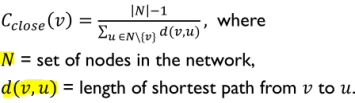
3. Interpretation: 
    * smaller total shortest path lengths of a node n to all other nodes will result in larger centrality value; hence, the closer it is to all other nodes, the more central a node is.
    * In social networks, we wanted to spread an innovation or a new product among the actors in the fastest amount of time, we would want to give it to the node with the highest closeness centrality first.

In [60]:
closeness_centrality_df = pd.DataFrame(nx.closeness_centrality(directed_graph).items(), 
                                       columns=["node", "closeness_centrality"])
closeness_centrality_df.sort_values("closeness_centrality", ascending=False).head(10)

,node,closeness_centrality
34,Jean,0.604329
28,Venti,0.542871
16,Albedo,0.525072
29,Diona,0.508403
24,Lisa,0.492760
19,Barbara,0.492760
10,Diluc,0.492760
13,Xingqiu,0.478051
5,Kaeya,0.471021
6,Klee,0.471021


### Based on the closeness centrality results, Jean is also the the most important character with closeness centrality of 0.604. It implies that Jean is closer to all the other nodes with relative shorter shorest path lengths connecting all the other character. If the characters want to find someone to help spread the news in the fastest amount of time, Jean would be a good person to do.

### 2.3 Betweenness centrality (In-between/broker/bridge/middleman importance)

1. Assumption: : important nodes will be the broker on the way to connect two other nodes without being directly connected to every node.

2. Definition: quantifies the sum of (the number of times a node acts as a bridge/middleman along the shortest path between two other nodes) / (the total number of existing shortest paths between two other nodes)
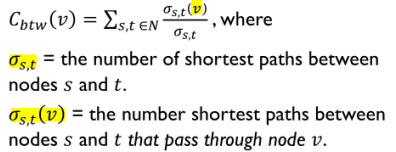

3. Interpretation: 
    * Higher sum of fractions means more shortest paths between any two nodes in the
network will have the node n involved, which implies higher importance as a bridge or
a broker in the network.
    * When interpreting normalized betweenness centrality, the number stands for how
many percent of the shortest paths between pairs of nodes in the graph will pass
through a given node n.
    * The node with higher betweenness centrality is able to pass messages from a node a
to another node b by traversing relatively small distances.


In [64]:
betweenness_centrality_df = pd.DataFrame(nx.betweenness_centrality(directed_graph).items(), 
                                       columns=["node", "betweenness_centrality"])
betweenness_centrality_df.sort_values("betweenness_centrality", ascending=False).head(10)

,node,betweenness_centrality
16,Albedo,0.134878
13,Xingqiu,0.132108
34,Jean,0.096456
15,Beidou,0.094075
4,Zhongli,0.092939
28,Venti,0.092471
29,Diona,0.085169
14,Eula,0.084201
3,Xiangling,0.081891
8,Yanfei,0.069288


### Measuring the importance of node being the broker to connect the paths between any two other nodes, Albedo is the most import node with betweenness_centrality of 0.135. This implies that 13.5% of the shortest paths between any pair of nodes in the graph will pass through Albedo.

### Edge betweenness centrality: 

### We can apply the same framework to find an important edge that has node s and node t pass through the edge instead of a node.
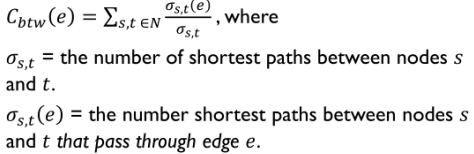

In [66]:
edge_betweenness_centrality_df = pd.DataFrame(nx.edge_betweenness_centrality(directed_graph).items(), 
                                       columns=["edge", "betweenness_centrality"])
edge_betweenness_centrality_df.sort_values("betweenness_centrality", ascending=False).head(10)

,edge,betweenness_centrality
127,"(Albedo, Xingqiu)",0.118807
108,"(Eula, Yanfei)",0.063184
96,"(Ningguang, Jean)",0.060183
223,"(Diona, Xiangling)",0.060026
117,"(Beidou, Kaedehara Kazuha)",0.055462
37,"(Zhongli, Venti)",0.043013
211,"(Xiao, Venti)",0.038645
28,"(Xiangling, Diona)",0.036625
104,"(Xingqiu, Beidou)",0.036291
180,"(Kaedehara Kazuha, Kamisato Ayaka)",0.028571


### Measuring the importance of edge being the bridge to connect the shortest paths between any two other nodes, the edge of `Albedo->Xingqiu` is the most import edge with betweenness_centrality of 0.119. This implies that 11.9% of the shortest paths between any pair of nodes in the graph will pass through this edge.

### 2.4 PageRank centrality (global inward importance)

1. Assumption: a node’s importance is dependent on other incoming node’s importance

2. Definition: PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages.

3. How to compute:
    * Assign all nodes a PageRank of 1/n, where n is the number of nodes.
    * Perform the following for k times:
        * Apply the Basic PageRank Update Rule: each node gives an equal share of its PageRank to all the nodes it links to.
        * Update the PageRank for each node to the sum of all the source nodes’ PageRank a node


3. Interpretation: 
    * The PageRank of a node at step 𝑘 is the probability that a random walker lands on the node after taking 𝑘 steps
    * A node with higher PageRank value will more likely be visited in the network.

In [68]:
pagerank_centrality_df = pd.DataFrame(nx.pagerank(directed_graph).items(), 
                                       columns=["node", "pagerank_centrality"])
pagerank_centrality_df.sort_values("pagerank_centrality", ascending=False).head(10)

,node,pagerank_centrality
34,Jean,0.061477
24,Lisa,0.055283
6,Klee,0.046893
5,Kaeya,0.046560
4,Zhongli,0.042101
10,Diluc,0.040697
16,Albedo,0.040236
19,Barbara,0.039043
17,Amber,0.036527
15,Beidou,0.033857


### From the above sorted result table, we can observe Jean is the most important character in the network by PageRank score of 0.06. This implies Jean received more important in-ward mentions in the entire network. The PageRank of Jean at step 100 is the probability that a random walker passing informtion on the network stopped at Jean after taking 100 steps. And the probability is 6%.

### 2.5 Authority and Hub scores (inward and outward importance):

1. Definition:  
For each node/web page:
* Authority score (inward importance) estimates the value of the content of the page/inward link contributions.
* Hub score (outward importance) estimates the value of a node's links to other pages.

2. How to compute:
    * **Hyperlink-Induced Topic Search** (HITS; also known as hubs and authorities) is a link analysis algorithm that rates Web pages:
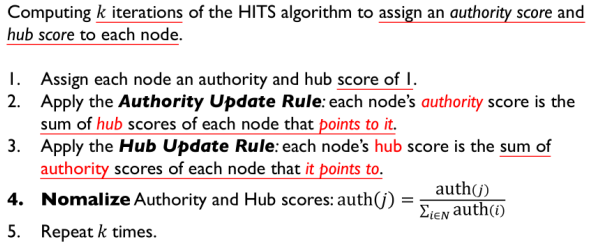

3. Interpretation: 
    * A good **hub** (points out) represents a page that pointed to many good authorities.
    * A good **authority** (takes in) represents a page that is linked by many good hubs
    * For most networks, as 𝑘 gets larger, authority and hub scores converge to a unique value

In [74]:
# compute hub and auth centrality scores
hub_scores, auth_scores = nx.hits(directed_graph)
hub_centrality_df = pd.DataFrame(hub_scores.items(), 
                           columns=["node", "hub_centrality"])
auth_centrality_df = pd.DataFrame(auth_scores.items(), 
                           columns=["node", "auth_centrality"])

In [75]:
hub_centrality_df.sort_values("hub_centrality", ascending=False).head(10)

,node,hub_centrality
25,Traveler,0.067400
24,Lisa,0.063647
34,Jean,0.058049
5,Kaeya,0.057443
6,Klee,0.056526
14,Eula,0.055123
29,Diona,0.052835
21,Sucrose,0.052102
20,Rosaria,0.051441
17,Amber,0.046236


### From the above hub scores, we can observe `Traveler` is the most important node because it has connected towards many good authority nodes. This finding is consistent with the out-degree centrality.

In [76]:
auth_centrality_df.sort_values("auth_centrality", ascending=False).head(10)

,node,auth_centrality
34,Jean,0.087187
24,Lisa,0.078032
5,Kaeya,0.071204
6,Klee,0.071027
10,Diluc,0.068840
16,Albedo,0.059420
19,Barbara,0.058982
17,Amber,0.058861
31,Noelle,0.047104
21,Sucrose,0.035925


### From the above auth scores, we can observe `Jean` is the most important node because it recevied many links from good hub nodes. This finding is consistent with the in-degree centrality.

## 3. Centrality Summary

In [86]:
# combine centrality measurement results
centrality_summary = in_degree_centrality_df\
    .merge(out_degree_centrality_df, on="node")\
    .merge(pagerank_centrality_df, on="node")\
    .merge(closeness_centrality_df, on="node")\
    .merge(betweenness_centrality_df, on="node")\
    .merge(hub_centrality_df, on="node")\
    .merge(auth_centrality_df, on="node")
centrality_summary

,node,in_degree_centrality,out_degree_centrality,pagerank_centrality,closeness_centrality,betweenness_centrality,hub_centrality,auth_centrality
0,Xinyan,0.205882,0.176471,0.024052,0.400368,0.009983,0.006785,0.006380
1,Keqing,0.147059,0.264706,0.020603,0.355882,0.006429,0.009574,0.005691
2,Bennett,0.205882,0.205882,0.026852,0.376817,0.005751,0.038416,0.034150
3,Xiangling,0.264706,0.235294,0.030609,0.464194,0.081891,0.009399,0.014293
4,Zhongli,0.323529,0.235294,0.042101,0.427059,0.092939,0.008452,0.010641
5,Kaeya,0.382353,0.323529,0.046560,0.471021,0.033551,0.057443,0.071204
6,Klee,0.382353,0.323529,0.046893,0.471021,0.038863,0.056526,0.071027
7,Mona,0.147059,0.205882,0.024750,0.427059,0.007703,0.045690,0.023333
8,Yanfei,0.147059,0.264706,0.019851,0.421440,0.069288,0.009935,0.010727
9,Chongyun,0.117647,0.205882,0.016459,0.372435,0.005310,0.006443,0.004421


### Rank node importance by centrality measure

In [126]:
centrality_ranks = centrality_summary.rank(ascending=False, 
                                           numeric_only=True, 
                                           method="dense").astype(int)
centrality_ranks.insert(loc=0, column='node', value=centrality_summary["node"])
centrality_ranks.sort_values("in_degree_centrality").style.background_gradient(subset=list(centrality_ranks.columns[1:]))

,node,in_degree_centrality,out_degree_centrality,pagerank_centrality,closeness_centrality,betweenness_centrality,hub_centrality,auth_centrality
34,Jean,1,3,1,1,3,3,1
24,Lisa,2,2,2,5,13,2,2
5,Kaeya,3,3,4,7,14,4,3
6,Klee,3,3,3,7,12,5,4
10,Diluc,4,7,6,5,19,18,5
19,Barbara,5,5,8,5,18,12,7
16,Albedo,5,7,7,3,1,17,6
4,Zhongli,5,5,5,11,5,26,24
15,Beidou,6,6,10,13,4,31,19
12,Ningguang,6,5,11,12,11,20,20


### With so many measures, it's  hard to study which one is important. We use ensemble approach by taking the average centrality to study which one is the most important node.

### Average Ranking

In [128]:
# compute the average ranking using the above ranks
average_ranks = pd.DataFrame(round(centrality_ranks.mean(axis=1)).astype(int), columns=["average_rank"])
average_ranks.insert(loc=0, column='node', value=centrality_summary["node"])
average_ranks.sort_values("average_rank").reset_index(drop=True)\
    .style.background_gradient(subset=["average_rank"])

,node,average_rank
0,Jean,2
1,Lisa,4
2,Kaeya,5
3,Klee,5
4,Albedo,7
5,Venti,9
6,Barbara,9
7,Diluc,9
8,Diona,10
9,Eula,10


### After computing the average ranking, Jean is the most important character in the Genshin Impact character story and voice mention network with average rank of 2. Ayaka is the least important character based on the average ranking. 